# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [33]:
# import libraries
# import libraries
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import nltk
nltk.download('stopwords')
nltk.download('wordnet') # download for lemmatization
nltk.download("averaged_perceptron_tagger")
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, make_scorer, f1_score



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC-1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC-1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\PC-1\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# load data from database
engine = create_engine('sqlite:///data/disaster.db')


In [3]:
sql = "select * from model_data4"
df = pd.read_sql(sql, con=engine)

In [4]:
df

,index,id,message,original,genre,related,request,offer,aid_related,medical_help,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
2,2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26211,26211,30261,The training demonstrated how to enhance micro...,None,news,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26212,26212,30262,A suitable candidate has been selected and OCH...,None,news,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26213,26213,30263,"Proshika, operating in Cox's Bazar municipalit...",None,news,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26214,26214,30264,"Some 2,000 women protesting against the conduc...",None,news,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Have a quick overview on the dataset
df.describe()

,index,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26216.000000,26216.00000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,...,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000
mean,13107.500000,15224.82133,0.773650,0.170659,0.004501,0.414251,0.079493,0.050084,0.027617,0.017966,...,0.011787,0.043904,0.278341,0.082202,0.093187,0.010757,0.093645,0.020217,0.052487,0.193584
std,7568.051665,8826.88914,0.435276,0.376218,0.066940,0.492602,0.270513,0.218122,0.163875,0.132831,...,0.107927,0.204887,0.448191,0.274677,0.290700,0.103158,0.291340,0.140743,0.223011,0.395114
min,0.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6553.750000,7446.75000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13107.500000,15662.50000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,19661.250000,22924.25000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,26215.000000,30265.00000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 0, 'Number of messages')

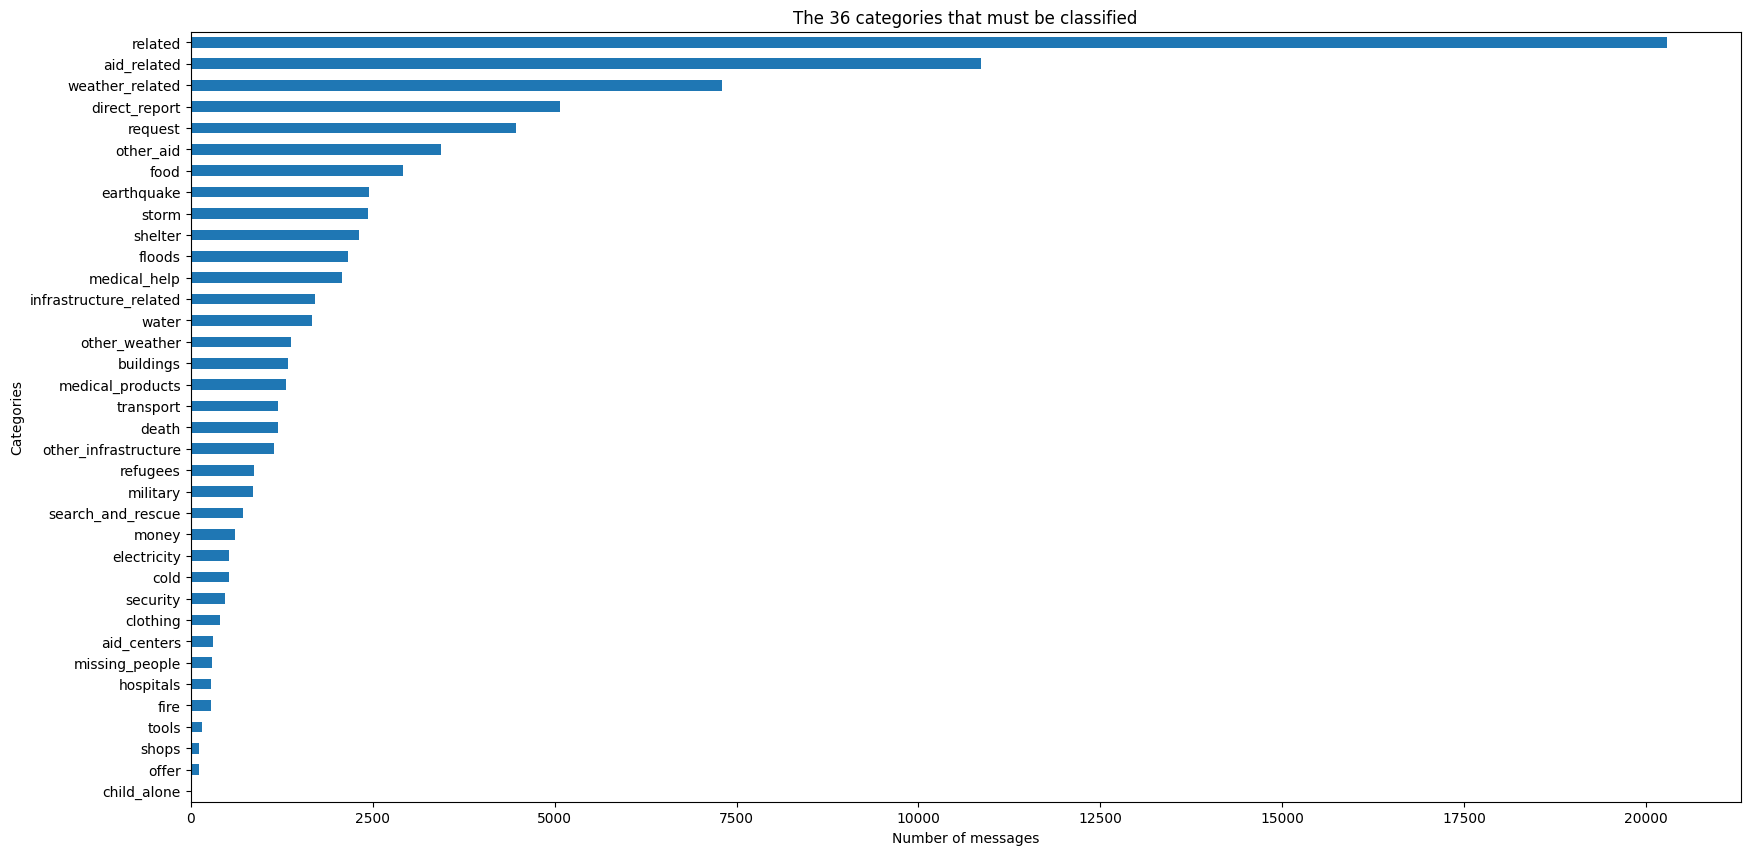

In [6]:
cats=df.columns[5:]
plt.figure(figsize=(20,10))
df[cats].sum().sort_values().plot.barh()
plt.title('The 36 categories that must be classified')
plt.ylabel('Categories')
plt.xlabel('Number of messages')


In [7]:
# We remove 'child_alone' column as it has no values.
df = df.drop(['child_alone', 'offer', 'tools'], axis = 1)


In [8]:
# Maximum value for 'related' column is '2'. Let us investigate further.
df.groupby('related').count()


,index,id,message,original,genre,request,aid_related,medical_help,medical_products,search_and_rescue,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
related,,,,,,,,,,,,,,,,,,,,,
0,6122,6122,6122,3395,6122,6122,6122,6122,6122,6122,...,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122
1,19906,19906,19906,6643,19906,19906,19906,19906,19906,19906,...,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906
2,188,188,188,132,188,188,188,188,188,188,...,188,188,188,188,188,188,188,188,188,188


In [9]:
# Maximum value for 'related' column is '2'. Fix by replacing 2 by 1 for now. We can update later.
df['related'] = df['related'].map(lambda x: 1 if x==2 else x)


In [10]:
X = df[["message", "genre"]]
Y = df.iloc[:,5:]


In [11]:
X


,message,genre
0,Weather update - a cold front from Cuba that c...,direct
1,Is the Hurricane over or is it not over,direct
2,Looking for someone but no name,direct
3,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,"says: west side of Haiti, rest of the country ...",direct
...,...,...
26211,The training demonstrated how to enhance micro...,news
26212,A suitable candidate has been selected and OCH...,news
26213,"Proshika, operating in Cox's Bazar municipalit...",news
26214,"Some 2,000 women protesting against the conduc...",news


In [12]:
Y


,related,request,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26211,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26212,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26213,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26214,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Distribution of class
Y.sum()/len(Y)

related                   0.766478
request                   0.170659
aid_related               0.414251
medical_help              0.079493
medical_products          0.050084
search_and_rescue         0.027617
security                  0.017966
military                  0.032804
water                     0.063778
food                      0.111497
shelter                   0.088267
clothing                  0.015449
money                     0.023039
missing_people            0.011367
refugees                  0.033377
death                     0.045545
other_aid                 0.131446
infrastructure_related    0.065037
transport                 0.045812
buildings                 0.050847
electricity               0.020293
hospitals                 0.010795
shops                     0.004577
aid_centers               0.011787
other_infrastructure      0.043904
weather_related           0.278341
floods                    0.082202
storm                     0.093187
fire                

### 2. Write a tokenization function to process your text data

In [14]:
def tokenize(text):
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    # detect all URL present in the messages
    detected_urls = re.findall(url_regex, text)
    # replace URL with "urlplaceholder"
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

In [15]:

# def tokenize(text):
#
#     # Normalize and tokenize and remove punctuation
#     words = word_tokenize(re.sub(r"[^a-zA-Z0-9]", " ", text.lower()))
#
#     # Remove stopwords.
#     words = [w for w in words if w not in stopwords.words("english")]
#
#     # Reduce words to their root form
#     lemmed = [WordNetLemmatizer().lemmatize(w) for w in words]
#
#     return lemmed


In [16]:
#X["tokenised"] = X["message"].apply(lambda x: tokenize(x))

In [17]:
X

,message,genre
0,Weather update - a cold front from Cuba that c...,direct
1,Is the Hurricane over or is it not over,direct
2,Looking for someone but no name,direct
3,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,"says: west side of Haiti, rest of the country ...",direct
...,...,...
26211,The training demonstrated how to enhance micro...,news
26212,A suitable candidate has been selected and OCH...,news
26213,"Proshika, operating in Cox's Bazar municipalit...",news
26214,"Some 2,000 women protesting against the conduc...",news


### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.



### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [18]:
def pipeline1(clf = RandomForestClassifier(random_state = 1)):
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(clf))
    ])
    return pipeline

In [19]:
Y

,related,request,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26211,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26212,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26213,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26214,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
X_load = X["message"].values
Y_load = Y.values
X_train, X_test, y_train, y_test = train_test_split(X_load, Y_load, random_state = 1)
pipeline = pipeline1()
pipeline.get_params().keys()

print("Xtrain size: {}".format(X_train.shape[0]))
print("Ytrain size: {}".format(y_train.shape[0]))


Xtrain size: 19662
Ytrain size: 19662


In [21]:
%%time
_ = pipeline.fit(X_train, y_train)


C:\Users\PC-1\Documents\GitHub\data-science\venv\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: total: 15min 57s
Wall time: 15min 57s


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [22]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, target_names = list(Y.columns.values)))


                        precision    recall  f1-score   support

               related       0.81      0.97      0.88      5004
               request       0.91      0.45      0.60      1139
           aid_related       0.79      0.60      0.68      2739
          medical_help       0.67      0.06      0.10       553
      medical_products       0.76      0.05      0.10       349
     search_and_rescue       0.67      0.02      0.05       167
              security       0.50      0.01      0.02       112
              military       0.67      0.02      0.04       190
                 water       0.90      0.22      0.35       430
                  food       0.88      0.41      0.56       754
               shelter       0.89      0.23      0.36       576
              clothing       0.78      0.07      0.13        99
                 money       1.00      0.01      0.03       141
        missing_people       0.67      0.03      0.05        80
              refugees       0.33      

C:\Users\PC-1\Documents\GitHub\data-science\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC-1\Documents\GitHub\data-science\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC-1\Documents\GitHub\data-science\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

### 6. Improve your model
Use grid search to find better parameters.


In [23]:
def mid_f1(y_true, y_pred):
    f1_list = []
    for i in range(np.shape(y_pred)[1]):
        f1 = f1_score(np.array(y_true)[:, i], y_pred[:, i])
        f1_list.append(f1)

    score = np.median(f1_list)
    return score

In [24]:
%%time
#Grid search

pipeline_1 = pipeline1()

parameters = {'vect__min_df': [1, 5],
              'tfidf__use_idf':[True, False],
              'clf__estimator__n_estimators':[10, 25],
              'clf__estimator__min_samples_split':[5, 10]}

scorer = make_scorer(mid_f1)
pipeline_cv = GridSearchCV(estimator=pipeline_1, param_grid=parameters, cv=3, verbose=10, n_jobs=-1)


CPU times: total: 0 ns
Wall time: 1 ms


In [25]:
%%time
np.random.seed(333)
pipeline_cv.fit(X_train, y_train)
print('Best Parameters:', pipeline_cv.best_params_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


C:\Users\PC-1\Documents\GitHub\data-science\venv\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Best Parameters: {'clf__estimator__min_samples_split': 10, 'clf__estimator__n_estimators': 25, 'tfidf__use_idf': True, 'vect__min_df': 5}
CPU times: total: 1min 38s
Wall time: 6min 51s


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [26]:
y_pred = pipeline_cv.predict(X_test)
print(classification_report(y_test, y_pred, target_names = list(Y.columns.values)))


                        precision    recall  f1-score   support

               related       0.82      0.97      0.89      5004
               request       0.87      0.47      0.61      1139
           aid_related       0.76      0.63      0.69      2739
          medical_help       0.62      0.14      0.22       553
      medical_products       0.79      0.13      0.22       349
     search_and_rescue       0.56      0.08      0.15       167
              security       0.00      0.00      0.00       112
              military       0.47      0.07      0.13       190
                 water       0.89      0.38      0.53       430
                  food       0.82      0.63      0.72       754
               shelter       0.81      0.37      0.50       576
              clothing       0.85      0.17      0.29        99
                 money       1.00      0.02      0.04       141
        missing_people       1.00      0.03      0.05        80
              refugees       0.66      

C:\Users\PC-1\Documents\GitHub\data-science\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC-1\Documents\GitHub\data-science\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC-1\Documents\GitHub\data-science\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [27]:
# Engineer new features.
class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

# Try an adaptive boosting model.
def pipeline2(clf  = AdaBoostClassifier(random_state = 1)):
     pipeline = Pipeline([
         ('features', FeatureUnion([
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),
            ('starting_verb', StartingVerbExtractor())
         ])),
         ('clf', MultiOutputClassifier(clf))
     ])
     return pipeline

# pipeline = pipeline2()

# get list of model parameters
# pipeline.get_params().keys()

# pipeline2 = ML_pipeline()


In [28]:
parameters_ada = {
    'clf__estimator__learning_rate': [0.1, 0.3],
    'clf__estimator__n_estimators': [100, 200]
}

In [29]:
#pipeline_cv = GridSearchCV(estimator=pipeline, param_grid=parameters_ada, cv=3, scoring='f1_weighted', verbose=3)
pipeline_2 = pipeline2()
pipeline_cv = GridSearchCV(estimator=pipeline_2, param_grid=parameters_ada, cv=3, verbose=10, n_jobs=-1)


In [30]:
%%time
np.random.seed(333)
pipeline_cv.fit(X_train, y_train)
print('Best Parameters:', pipeline_cv.best_params_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\PC-1\Documents\GitHub\data-science\venv\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Best Parameters: {'clf__estimator__learning_rate': 0.3, 'clf__estimator__n_estimators': 200}
CPU times: total: 10min 49s
Wall time: 21min 14s


In [31]:
y_pred = pipeline_cv.predict(X_test)
print(classification_report(y_test, y_pred, target_names = list(Y.columns.values)))


                        precision    recall  f1-score   support

               related       0.82      0.97      0.89      5004
               request       0.83      0.53      0.65      1139
           aid_related       0.79      0.58      0.67      2739
          medical_help       0.65      0.19      0.29       553
      medical_products       0.69      0.23      0.34       349
     search_and_rescue       0.52      0.10      0.17       167
              security       0.67      0.02      0.03       112
              military       0.52      0.23      0.32       190
                 water       0.78      0.63      0.70       430
                  food       0.81      0.71      0.76       754
               shelter       0.81      0.50      0.62       576
              clothing       0.80      0.43      0.56        99
                 money       0.65      0.20      0.30       141
        missing_people       0.79      0.19      0.30        80
              refugees       0.67      

C:\Users\PC-1\Documents\GitHub\data-science\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC-1\Documents\GitHub\data-science\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC-1\Documents\GitHub\data-science\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

### 9. Export your model as a pickle file


In [32]:
pickle.dump(pipeline_cv, open('disaster_ada_model.sav', 'wb'))


### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.